# Prova de conceitos - Delay Sum

O objetivo desse jupyter é verificar alguns conceitos relacionados à beamforming e se os algoritmos implementados até agora estão corretos.

Serão implementados três testes:

1) Padrão de direção para várias SNRs: plotar o directivity pattern para alguns valores de SNR.

2) Ganho em SNR do beamforming: plotar um gráfico que mostre a SNR saida do delay sum em função da SNR de entrada.

3) Diferença entre os ângulos estimados pelo delay sum e os ângulos verdadeiros: plotar RMSE dos ângulos em função da SNR.

In [1]:
import librosa
import sys
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from random import randint
from IPython.display import Audio

sys.path.append('/home/dimi/Programming/IC2019/DOA/Python')
from GeneralizedSidelobeCancellerClass import GeneralizedSidelobeCanceller
from SimularArrayMicrofonesClass import SimularArrayMicrofones

In [2]:
# DEFININDO ALGUNS PARÂMETROS PARA PLOTAR GRÁFICOS
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
params = {'figure.figsize': [10, 5], 
          'axes.labelsize': 10,
          'axes.titlesize':14, 
          'font.size': 10,
          'legend.fontsize': 10, 
          'xtick.labelsize': 8, 
          'ytick.labelsize': 8
         }
plt.rcParams.update(params)

In [3]:
def grausParaRad(angRad):
    return (angRad * np.pi)/180

In [4]:
def radParaGraus(angGraus):
    return (angGraus * 180)/np.pi

In [5]:
def calcularEnerigaRuidoDadoSNR(snrDesejada, energiaSinal):
    return energiaSinal/(10**(snrDesejada/10))

## 1) Padrão de direção para várias SNRs

Passo a passo para essa etapa:

1) Selecionar um áudio.

2) Simular um array de microfones com esse áudio.

3) Plotar a energia do sinal após o delay sum em função dos ângulos.

4) Repetir os passos para alguns valores de SNR.

#### Abrindo um áudio qualquer para fazer o teste

In [6]:
caminho = "/home/dimi/Programming/IC2019/DOA/Gravacoes/Simulacoes/Gravacao3/sinalPuroMono6Segundos.wav"
sinalOriginal, freqAmostragem = librosa.core.load(caminho, sr=None, mono=True)

In [7]:
Audio(data=sinalOriginal, rate=freqAmostragem)

#### Normalizando o áudio pela energia

Basta deslocar a média para 0 e dividir o sinal pelo seu desvio padrão.

In [8]:
sinalOriginal = (sinalOriginal-np.mean(sinalOriginal))/np.std(sinalOriginal)
print(np.var(sinalOriginal))

1.0


#### Simulo um array de microfones 

Antes, preciso definir quais vão ser as coordenadas dos microfones para depois fazer o cálculo de ângulos. As coordenadas abaixo são as do ReSpeaker 4-Mic Array, mas após uma rotação para que os microfones tivessem componentes no eixo z.

In [9]:
# RESPEAKER 
coordenadasMics = [
    [0.0000, 0.00000, 0.00000],
    [0.0000, 0.04137, 0.04137],
    [0.0585, 0.04137, 0.04137],
    [0.0585, 0.00000, 0.00000]
]

# DREGON DATASET
# coordenadasMics = [
#     [0.0420, 0.0615, -0.0410],
#     [-0.0420, 0.0615, 0.0410],
#     [-0.0615, 0.0420, -0.0410],
#     [-0.0615, -0.0420, 0.0410],
#     [-0.0420, -0.0615, -0.0410],
#     [0.0420, -0.0615, 0.0410],
#     [0.0615, -0.0420, -0.0410],
#     [0.0615, 0.0420, 0.0410]
# ]

In [10]:
objSimularArrayMics = SimularArrayMicrofones(caminho, energiaRuido=1, normalizarEnergia=True, coordenadasMics=coordenadasMics)
arraySinaisSimulados, arrayDelays, freqAmostragem = objSimularArrayMics.obterResultado()

print("\nDelays entre os microfones (amostras):", arrayDelays)


Delays entre os microfones (amostras): [0, 4, 6, 2]


In [11]:
Audio(data=np.sum(arraySinaisSimulados, axis=0), rate=freqAmostragem)

#### Uso a classe do GSC pra fazer o delay sum

In [12]:
objBeamforming = GeneralizedSidelobeCanceller()

sinalBeamformado, __ = objBeamforming.gerarSinalBeamformado(arraySinaisSimulados, arrayDelays)

In [13]:
Audio(data=sinalBeamformado, rate=freqAmostragem)

In [14]:
np.var(sinalBeamformado)

1.1407996356832748

In [15]:
np.var(np.sum(arraySinaisSimulados, axis=0))

31.28883151874416

#### Gerando os gráficos 2D

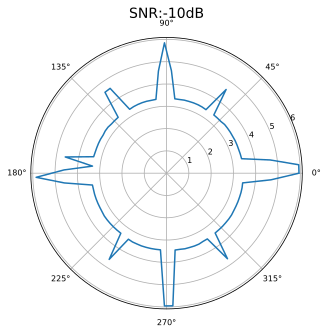

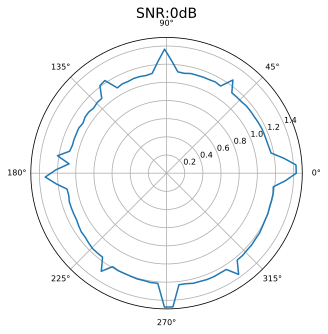

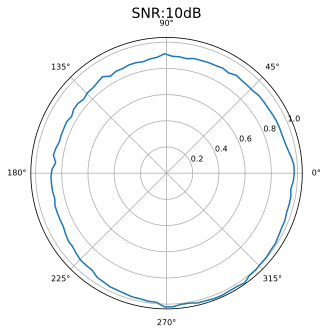

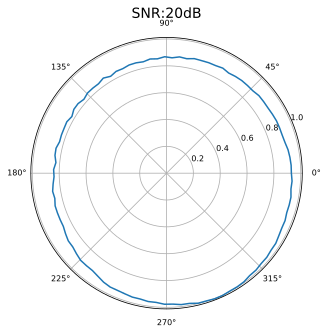

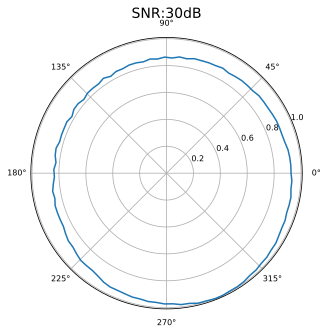

CPU times: user 6.06 s, sys: 989 ms, total: 7.05 s
Wall time: 5.13 s


In [18]:
%%time

# ESPECIFICANDO QUAIS SERAO OS ANGULOS VERDADEIROS: None para angulos aleatorios (EM RAD)
azimutalGrausVerdadeiro = randint(-180, 180)
elevacaoGrausVerdadeiro = 0
azimutalRadVerdadeiro   = grausParaRad(azimutalGrausVerdadeiro)
elevacaoRadVerdadeiro   = grausParaRad(elevacaoGrausVerdadeiro)

for SNRAtual in range(-10, 31, 10):

    # DEFININDO A ENERGIA DO RUIDO PARA SER DA SNR QUE EU QUERO
    energiaRuido = calcularEnerigaRuidoDadoSNR(snrDesejada=SNRAtual, energiaSinal=1)

    # SIMULANDO UM ARRAY DE MICROFONES COM OS ANGULOS ESPECIFICADOS
    objSimularArrayMics = SimularArrayMicrofones(caminho, energiaRuido, True, azimutalRadVerdadeiro, elevacaoRadVerdadeiro, coordenadasMics)
    arraySinaisSimulados, __, freqAmostragem = objSimularArrayMics.obterResultado()

    # ARRAYS PARA GUARDAR OS RESULTADOS
    arrayAngulosAzimutais     = []
    arrayEnergiasAposDelaySum = []

    # PARA CADA ANGULO AZIMUTAL
    qtd = 100
    for azimutalRadAtual in np.linspace(0, 2*np.pi, qtd):

        # SABENDO OS ANGULOS ATUAIS, PRECISO DEFINIR AS DEFASAGENS DA DIRECAO ATUAL
        arrayDelays = objSimularArrayMics.obterArrayDelays(coordenadasMics, freqAmostragem, azimutalRadAtual, elevacaoRadVerdadeiro)

        # GERANDO O SINAL BEAMFORMADO DE ACORDO COM OS DELAYS ENCONTRADOS
        sinalBeamformado, __ = objBeamforming.gerarSinalBeamformado(arraySinaisSimulados, arrayDelays)

        # GUARDANDO AS INFORMACOES NOS ARRAYS DE RESULTADOS
        arrayAngulosAzimutais.append(azimutalRadAtual)
        arrayEnergiasAposDelaySum.append(np.var(sinalBeamformado))

    # PRINTANDO
    ax = plt.subplot(111, projection='polar')
    ax.plot(arrayAngulosAzimutais, arrayEnergiasAposDelaySum)
    plt.title("SNR:" + str(SNRAtual) + "dB")
    ax.grid(True)
    plt.show()

#### Varrendo o delay sum por todo o espaço 3D

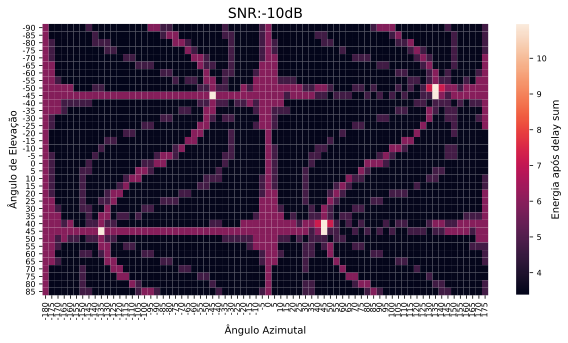

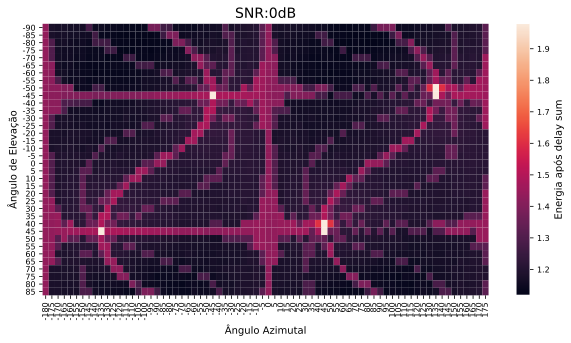

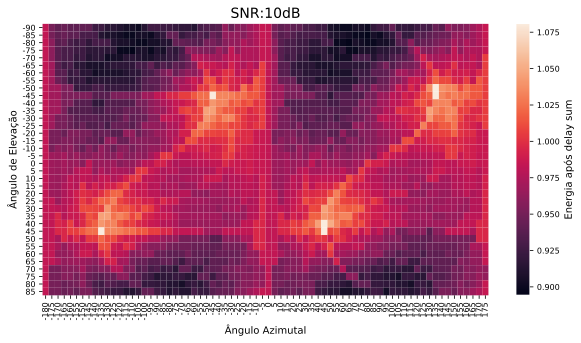

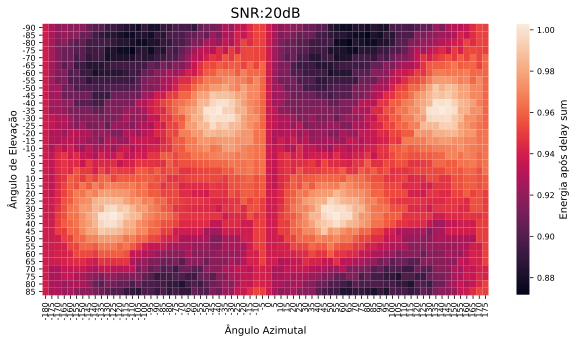

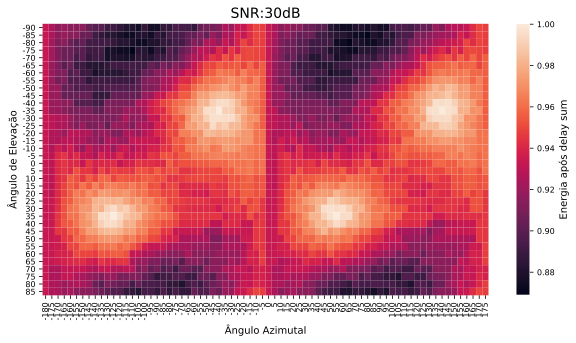

CPU times: user 1min 49s, sys: 3.83 s, total: 1min 53s
Wall time: 1min 46s


In [20]:
%%time

# ESPECIFICANDO QUAIS SERAO OS ANGULOS VERDADEIROS: None para angulos aleatorios (EM RAD)
azimutalGrausVerdadeiro = randint(-180, 180)
elevacaoGrausVerdadeiro = randint(-90, 90)
azimutalRadVerdadeiro   = grausParaRad(azimutalGrausVerdadeiro)
elevacaoRadVerdadeiro   = grausParaRad(elevacaoGrausVerdadeiro)

for SNRAtual in range(-10, 31, 10):
    # DEFININDO A ENERGIA DO RUIDO PARA SER DA SNR QUE EU QUERO
    energiaRuido = calcularEnerigaRuidoDadoSNR(snrDesejada=SNRAtual, energiaSinal=1)

    # SIMULANDO UM ARRAY DE MICROFONES COM OS ANGULOS ESPECIFICADOS
    objSimularArrayMics = SimularArrayMicrofones(caminho, energiaRuido, True, azimutalRadVerdadeiro, elevacaoRadVerdadeiro, coordenadasMics)
    arraySinaisSimulados, __, freqAmostragem = objSimularArrayMics.obterResultado()

    # ARRAYS PARA GUARDAR OS RESULTADOS
    arrayAngulosAzimutais       = []
    arrayAngulosElevacao        = []
    arrayEnergiasAposDelaySum   = []

    # APLICANDO O BEAMFORMING EM TODAS AS DIRECOES DO ESPACO 3D
    passo = 5
    for azimutalAtual in range(-180, 180, passo):
        for elevacaoAtual in range(-90, 90, passo):

            # SABENDO OS ANGULOS ATUAIS, PRECISO DEFINIR AS DEFASAGENS DA DIRECAO ATUAL
            arrayDelays = objSimularArrayMics.obterArrayDelays(coordenadasMics, freqAmostragem, grausParaRad(azimutalAtual), grausParaRad(elevacaoAtual))

            # GERANDO O SINAL BEAMFORMADO DE ACORDO COM OS DELAYS ENCONTRADOS
            sinalBeamformado, __ = objBeamforming.gerarSinalBeamformado(arraySinaisSimulados, arrayDelays)

            # GUARDANDO AS INFORMACOES NOS ARRAYS DE RESULTADOS
            arrayAngulosAzimutais.append(azimutalAtual)
            arrayAngulosElevacao.append(elevacaoAtual)
            arrayEnergiasAposDelaySum.append(np.var(sinalBeamformado))

    # ORGANIZANDO OS ARRAYS
    arrayEnergiasAposDelaySum = np.reshape(arrayEnergiasAposDelaySum, (len(np.unique(arrayAngulosElevacao)), len(np.unique(arrayAngulosAzimutais))))
    angulosAzimutaisUnicos    = np.unique(arrayAngulosAzimutais)
    angulosElevacaoUnicos     = np.unique(arrayAngulosElevacao)

    heatmap = sns.heatmap(arrayEnergiasAposDelaySum, xticklabels=angulosAzimutaisUnicos, yticklabels=angulosElevacaoUnicos, cbar_kws={'label': 'Energia após delay sum'})
    plt.title("SNR:" + str(SNRAtual) + "dB")
    plt.xlabel("Ângulo Azimutal")
    plt.ylabel("Ângulo de Elevação")
    plt.show()

## 2) Ganho em SNR do beamforming